<a href="https://colab.research.google.com/github/jcandane/gym_rings/blob/main/ring_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ring Dataset for Calibration of Classification & Manifold Models

## defs

In [ ]:
import numpy as np

def define_ring(A, radii):
    """
    define a Boolean ring, such that the image is made from "True" or "1".
    A:np.ndarray (initial array)
    radius_range:tuple defined by (minimum radius, maximum radius)
    GET>
    A:np.ndarray (initial array with an additional ring with radius_range)
    """
    height, width = A.shape
    radii  = radii.reshape(-1,2).T

    center = np.array([width / 2, height / 2])
    I_xi   = np.indices((height, width)).reshape(2, -1) ## meshgrid -> flatten image
    I_xi   = np.vstack((I_xi[1], I_xi[0]))

    ### RINGS
    mask_i  = (np.linalg.norm(I_xi-center[:,None], axis=0)[:,None] >= radii[0][None,:]) ##&
    mask_i &= (np.linalg.norm(I_xi-center[:,None], axis=0)[:,None] <  radii[1][None,:])
    mask_i  = np.any(mask_i, axis=-1)

    A = A.reshape(-1)
    A[mask_i] = 1
    return A.reshape(N,N)

def ring_notch(image_shape, θ:np.ndarray, radius_range, notch_width=5.):
    """
    GIVEN>
    image_shape:tuple (The shape of the image (height, width))
    θ:np.ndarray[1d] (list of angles, θ.shape=(samples,))
    radius_range:np.ndarray (for a given ring, [R_min,R_max])
    notch_width:float (in degrees)
    GET>
    np.ndarray (A boolean mask for the notches)
    """
    height, width      = image_shape

    θ = (θ).astype(float)
    θ *= -1.
    #θ -= 1.*notch_width
    θ_min = np.deg2rad(θ - notch_width)
    θ_max = np.deg2rad(θ + notch_width)

    # Create a grid of x and y coordinates
    y, x = np.ogrid[:height, :width]

    # Calculate the distances and angles
    y = y - width / 2
    x = x - height / 2
    distance = np.sqrt(x**2 + y**2)
    angle    = np.arctan2(y, x) ## every pixel associated an angle

    # Normalize angles to [0, 2*pi)
    angle = np.mod(angle, 2 * np.pi)
    θ_min = np.mod(θ_min, 2 * np.pi)
    θ_max = np.mod(θ_max, 2 * np.pi)

    # Create the mask for the angle range
    R_min, R_max = radius_range
    R_min = float(R_min)-0.01
    R_max = float(R_max)+0.01

    shifted_angle     = (angle[:,:,None] - θ_min[None,None,:]) % 360 ### why not % 2*np.pi ???
    shifted_end_angle = (θ_max - θ_min) % 360
    angle_mask        = (shifted_angle <= shifted_end_angle[None,None,:])

    radius_mask = (distance <= R_max) & (distance > R_min)
    mask        = angle_mask & radius_mask[:,:,None]
    return mask.swapaxes(0,2).swapaxes(1,2) ### s.t. snapshots, pixels

def get_rings(N:int, θs:np.ndarray, radii, notch_width=5.): ##
    """
    GIVEN>
    N:int (image side size, such that image.shape=(N,N))
    θs:np.ndarray[2d] (list of angles for each ring, with θs.shape=(ring count, samples) )
    radii:np.ndarray[2] (with shape=(ring count, 2), i.e. axis=1 is the R_min, R_max for each ring)
    notch_width:float (notch angle, default=5 degrees, this can be generalized)
    GET>
    np.ndarray (dataset of shape=(θs.shape[1], N, N))
    """
    img_shape = (N,N)

    R    = define_ring(np.zeros(img_shape, dtype=bool), radii)
    mask = np.asarray([ ring_notch(img_shape, θs[r], radii[r], notch_width=notch_width) for r in range(len(radii))])
    mask = np.sum(mask, axis=0)

    return R[None,:,:]*np.logical_not( mask )

## Rings test

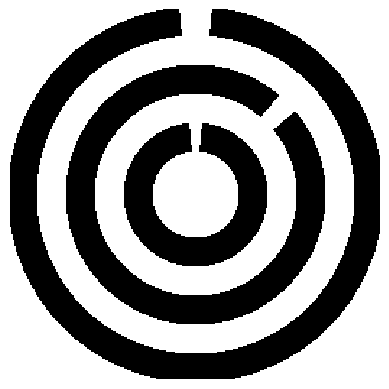

In [ ]:
import matplotlib.pyplot as plt

### input
N      = 256
angles = np.array([[90,270,180.,0,360,65,182, 234], [45,86,243,360,97,12, 311, 34], [90,270,90,5,156,65,182, 211]])
radii  = np.array([[30,50],[70,90],[110,130]])

### ouput
A    = get_rings(N, angles, radii)

plt.imshow(A[-8], interpolation='none', cmap='Greys')
plt.axis("off")
plt.show()

390.625 bool


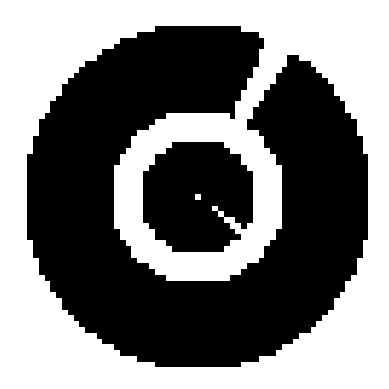

In [ ]:
import matplotlib.pyplot as plt

### input
N      = 64
angles = 360*np.random.rand(3,100000)
radii  = np.array([[1,10],[15,30]]) #np.array([[30,50],[70,90],[110,130]])

### ouput
A    = get_rings(N, angles, radii)


print(A.size/1024/1024, A.dtype)
plt.imshow(A[-8], interpolation='none', cmap='Greys')
plt.axis("off")
plt.show()